# Weighted mean

We should be able to calculate the domain mean by adding up the clear-sky and the cloudy-sky means, weighted by their relative spatial cover (i.e. cloud cover and it inverse).

Here we are looking at the radiation budget, but this should work for any variable.

$$
\bar{F_{AS}} = \bar{F_{CL}} \cdot clct - \bar{F_{CS}} (1 - clct)
$$

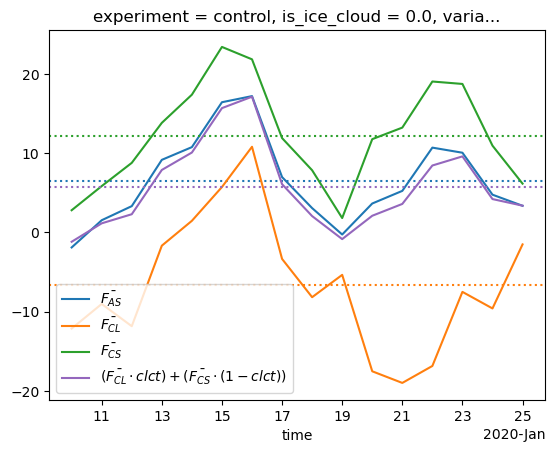

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import postprocessing as pp
import matplotlib.pyplot as plt

data = fh.disk_data_from_keywords('/scratch/m/m300872/temp', ['pp3'])
data = data.sel({'is_ice_cloud':0})
data = pp.daily_average(data)
data = data.where((data['samples_per_day'] > 140).compute(), drop=True)

fas1 = data.sel({'experiment':'control', 'is_cloud':None})['rad_budget']
clct = data.sel({'experiment':'control', 'is_cloud':None})['clct'] / 100
fcl  = data.sel({'experiment':'control', 'is_cloud':1})['rad_budget']
fcs  = data.sel({'experiment':'control', 'is_cloud':0})['rad_budget']
fas2 = fcl * clct + fcs * (1 - clct)

fig, ax = plt.subplots()
for var, label, color in zip([fas1, fcl, fcs, fas2], 
                             ['$\\bar{F_{AS}}$', '$\\bar{F_{CL}}$', '$\\bar{F_{CS}}$', '$(\\bar{F_{CL}} \\cdot clct) + (\\bar{F_{CS}} \\cdot (1 - clct))$'], 
                             ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']):
    var.plot(ax=ax, color=color, label=label)
    mean = var.mean(dim='time')
    ax.axhline(mean, ls=':', color=color)
ax.legend()
fig.show()

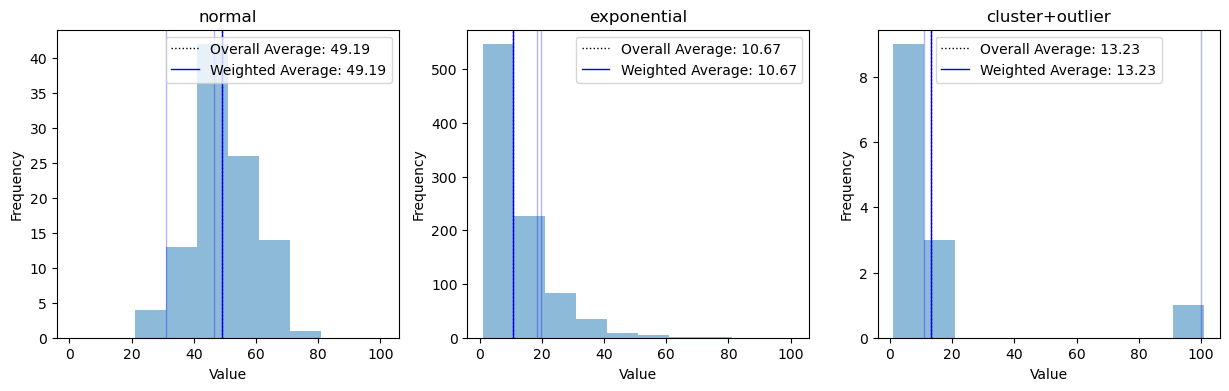

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data_fixed():
    """Generate a dataset with a non-uniform distribution and an outlier."""
    array = np.array([1, 2, 2, 3, 3, 3, 4, 4, 5, 1000])
    np.random.shuffle(array)
    return array

def generate_data_cluster_and_outlier():
    """Generate a dataset with distinct clusters and an outlier."""
    cluster1 = np.array([1, 1, 1, 2, 2, 2])
    cluster2 = np.array([10, 10, 10, 11, 11, 11])
    outlier = np.array([100])
    data = np.concatenate((cluster1, cluster2, outlier))
    return data

def generate_data_clusters():
    """Generate a dataset with distinct clusters."""
    cluster1 = np.array([1, 1, 1, 2, 2, 2])
    cluster2 = np.array([10, 10, 10, 11, 11, 11])
    data = np.concatenate((cluster1, cluster2))
    return data

def generate_data_outliers():
    """Generate a dataset with an outlier."""
    main_data = np.array([5, 5, 5, 5, 5, 5, 5, 5, 5])
    outlier = np.array([100])
    data = np.concatenate((main_data, outlier))
    return data

def generate_data_bimodal():
    """Generate a dataset with a bimodal distribution."""
    peaks = list()
    # peaks.append(np.random.normal(loc=10, scale=1, size=50))
    peaks.append(np.random.normal(loc=80, scale=10, size=50))
    peaks.append(np.random.normal(loc=30, scale=10, size=50))
    data = np.concatenate(peaks)
    np.random.shuffle(data)
    return data

def generate_data_pareto():
    """Generate a dataset with a pareto distribution."""
    data = (np.random.pareto(shape, 1000) + 1) * 10
    return data

def generate_data_normal_extremes():
    """Generate a dataset with a normal distribution plus outliers."""
    main_data = np.random.normal(loc=20, scale=10, size=100)
    extremes = np.array([100, 150, 200, 250, 300])
    data = np.concatenate((main_data, extremes))
    np.random.shuffle(data)
    return data

def generate_data_exponential():
    """Generate a dataset with an exponential distribution."""
    data = np.random.exponential(scale=10, size=1000)
    return data

def generate_data_log_normal():
    """Generate a dataset with a log normal distribution."""
    data = np.random.lognormal(1, 2, 100)
    return data

def generate_data_normal():
    """Generate a dataset with a nomral distribution."""
    return np.random.normal(loc=50, scale=10, size=100)

def split_data(data, num_subsets=2):
    """
    Splits a numpy array into a specified number of subsets, each containing unique elements.

    Args:
        data (numpy.ndarray): The input array to be split.
        num_subsets (int, optional): Number of subsets to split the data into. Defaults to 2.

    Returns:
        list[numpy.ndarray]: A list of numpy arrays, each representing a subset of the original data.
                             The size of each subset is randomly determined, but all elements are used exactly once.
    """
    if num_subsets >= len(data): raise ValueError("num_subsets must be less than len(data)")
    if num_subsets == 1: return [data]
    if num_subsets == len(data): return [np.array([x]) for x in data]
    
    data_copy = data.copy()
    np.random.shuffle(data_copy)
    
    split_points = np.random.randint(1, len(data_copy), num_subsets - 1)
    split_points = np.sort(np.unique(split_points))
    indices = [0] + split_points.tolist() + [len(data_copy)]
    
    subsets = []
    for i in range(num_subsets):
        start = indices[i]
        end = indices[i + 1]
        subsets.append(data_copy[start:end])
    return subsets

def weighted_average(subsets):
    ''' computes a weighted average, where the weight is the relative size of the subsets compared to all samples'''
    total_size = sum(len(subset) for subset in subsets)
    weights = (len(subset)/total_size for subset in subsets)
    weighted_averages = [np.mean(subset)*(len(subset)/total_size) for subset in subsets]
    return sum(weighted_averages)
    
def ax_histogram(ax, data, subsets):
    oa = np.mean(data)
    wa = weighted_average(subsets)
    
    ax.hist(data, bins=range(1, 102, 10), alpha=0.5) #, label='Data Distribution')
    ax.axvline(oa, color='black', linewidth=1, ls=':', label=f'Overall Average: {oa:.2f}')
    ax.axvline(wa, color='blue', linewidth=1, label=f'Weighted Average: {wa:.2f}')
    for subset in subsets:
        ax.axvline(subset[-1], color='b', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    return ax

# Main execution
datasets = [generate_data_normal(), generate_data_log_normal()]
labels   = ['normal', 'log normal']
datasets = [generate_data_normal(), generate_data_exponential(), generate_data_cluster_and_outlier()]
labels   = ['normal', 'exponential', 'cluster+outlier']
fig, axs = plt.subplots(1,len(datasets), figsize=(len(datasets)*5,4))
for ax, data, label in zip(axs, datasets, labels):
    subsets = split_data(data, 2)
    ax = ax_histogram(ax, data, subsets)
    ax.set_title(label)
fig.show()

And indeed we can show that the average of the whole population $\bar{X}$ is equal to sum of averages of each subset $k$, weighted by its relative size $\frac{n_k}{N}$:

$$
\bar{X} = \sum_{k=1}^{K} \left(\frac{n_k}{N} \cdot \bar{X}_k\right)
$$

We express the mean of the entire population, $\bar{X}$ as the sum over all observations in all subsets $\sum x_k$ divided by the total number of elements:

$$
\bar{X} = \frac{\sum_{k=1}^{K} \sum x_k}{N}
$$

Since $\bar{X}_k = \frac{\sum x_k}{n_k}$, we can express $\sum x_k$ as:

$$
\sum x_k = n_k \cdot \bar{X}_k
$$

and substitute this into the expression for $\bar{X}$:

$$
\bar{X} = \frac{\sum_{k=1}^{K} (n_k \cdot \bar{X}_k)}{N}
$$

Now, the weighted sum of averages

$$
\sum_{k=1}^{K} \left(\frac{n_k}{N} \cdot \bar{X}_k\right) 
$$

can be written as:
$$
\sum_{k=1}^{K} \frac{n_k \cdot \bar{X}_k}{N}
$$

This expression is identical to the expression for $\bar{X}$:

$$
\bar{X} = \frac{\sum_{k=1}^{K} (n_k \cdot \bar{X}_k)}{N} = \sum_{k=1}^{K} \frac{n_k \cdot \bar{X}_k}{N}
$$